# Пайплайн для выгрузки необработанных данных.
### Конвертация imzml данных спектров в hdf5.

Основная функция «imzml2hdf5» из модуля "pspectra" - конвертирует в другой формат сырые данные. Можно изменить тип данных для уменьшения размера (imzml хранится только в "double", он же float64).  
Из удобного в отличие от imzml:
1) Данные разных областей файла/имаджа хранятся порознь и чётко разделены, включая координаты
2) Можно сохранить в формате ‘single’, из-за чего весить будет в два раза меньше
3) Легче и быстрее выгружать батчами для обработки (не загружается весь файл, если настроить размер батча (в функции параметр "chunk_rowsize"))
4) Предварительная предобработка данных
5) Возможность объединить разные данные из разных 'imzml' в один файл.

Минусы:
1) Нельзя хранить дисконтинуальные данные (по крайней мере пока).
2) Много информации метаданных остаётся в imzml и hdf5 не может быть полной заменой.
3) Требует дополнительного места на жёстком диске того же размера или в два раза меньше, если изменить тип данных до "single" (float 32)

Вероятная цель использования: 
1) Работа с биннингом сырых данных.
2) Для тех, кто хочет сам покопаться в данных и обработать их иначе перед дальнейшим использованием, работая не в долгом цикле, а с матрицей данных или батчами матрицы.

## Пример и описание работы с функцией.
#### imzml2hdf5( path , dtypeconv , chunk_rowsize , chunk_bsize )
1) `path` - путь к папке/файлу `imzml`. Можно несколько путей списком: [path_1, path_2]. 
Если нужно работать только с одним файлом, то лучше указать прямой путь к нему (example: *r"D:\Testing\Our_data\Rapiflex\roi1_e046\roi1_e046.imzML"*).

    Если необходимо выгрузить сразу несколько файлов, то можно указать путь к общей папке (example: r"D:\Testing\Our_data\Rapiflex" или если имеется несколько файлов "imzml" в одной папке, то сработает и путь r"D:\Testing\Our_data\Rapiflex\roi1_e046\"). 

    Рекомендация: хранить данные imzml в одной папке или в соседних папках, если они относятся к одному эксперименту, снятые в один день, с одной и той же калибровкой, матрицей/источником ионов и настройками.

2) (Опционально) `dtypeconv` - указать тип данных ('double','single'(default),'half'(not recomended)), оптимально по эффективности и достаточной точности значений: "single"

3) (Опционально) `chunk_rowsize` - определяет кол-во строк при разделении матрицы в hdf5, чтобы не подгружать сразу все данные и занять всю оперативную память. Default: chunk_rowsize - "Auto", если "Auto", то кол-во строк определяется по значению `chunk_bsize` - размер куска разделённой матрицы в байтах (оптимально 10-100e6 (то есть 10-100 Мб)).

In [1]:
from pelmesha.pspectra import imzml2hdf5
path = r"D:\Testing\Our_data\Rapiflex\roi1_e046" # Write your path to the file 
imzml2hdf5(path)

Batches progress:   0%|          | 0/1 [00:00<?, ?it/s]

Rapiflex\roi1_e046\roi1_e046.imzML is waiting queue
roi1_e046 roi 00 data writing is in progress
D:\Testing\Our_data\Rapiflex\roi1_e046\roi1_e046.imzML data writing is finished


Конвертированный файл hdf5 с названием *"<folder_name>_rawdata.hdf5"* сохранится в папке выше от местонахождения файла imzml. 
Например, если path - путь к файлу *r"D:\Testing\Our_data\Rapiflex\roi1_e046\roi1_e046.imzML"*, *r"D:\Testing\Our_data\Rapiflex\roi1_e046"* или *r"D:\Testing\Our_data\Rapiflex"*, то файл сохранится в *r"D:\Testing\Our_data\Rapiflex"*:

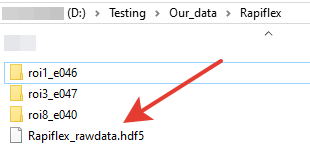

Если выгружаются сразу несколько файлов (example path: *r"D:\Testing\Our_data\Rapiflex"*), то все они будут храниться в одном файле *"<folder_name>_rawdata.hdf5"* в папке выше от них (в примере выше в папке: Rapiflex - *"Rapiflex_rawdata.hdf5"*).

Если указан путь ещё выше (вплоть до *"D:\ "*) (example path: *r"D:\Testing\Our_data" or r"D:\Testing"*), то функция найдёт все файлы imzml в подпапках и создаст несколько файлов "hdf5", при наличии достаточно далеко отстоящих файлов согласно описанному выше.

Функция не работает с discontinual данными, так как данные спектров разного размера (example - orbitrap data) и матрицу не составить из них.

## Загрузка конвертированных данных и их использование
Для загрузки конвертированных сырых данных используется функция "rawdata_Load" из модуля "loaders".
В функцию подаётся параметр path, в который можно задать прямой путь к файлу или к общей папке и загрузить несколько файлов. Также можно задать список путей: [path_1, path_2].

Эта функция основана на "hdf5py" пакете (https://docs.h5py.org/en/stable/). Для выгрузки данных используется стандартная для словарей индексация к датасету имаджа.

Пример пути к датасету: HDF5File[Slide][sample][roi][dataset], 

- где `Slide` - это группа датасетов из одного hdf5 файла.

- `sample` - это группа данных, в которую выгружены данные из одного imzml файла (название sample создаётся следующим образом: <_название корневой папки imzml_>_<_название файла imzml_>, если <_название корневой папки imzml_> идентично <_название файла imzml_>, то sample записывается без дублированного названия и '\_' между)

- `roi` - это группа данных, отвечающая за область измерения. В одном файле imzml может быть записано несколько областей с одного эксперимента (к примеру файлы от Rapiflex). Но для остальных приборов в основном там только одна область: "00"

- `dataset` - название записанных данных:
    - `mz` - одномерный вектор mz (1,N), где N - кол-во точек спектра. 
    - `int` - матрица интенсивностей (M,N), где каждая строка M - соответствует списку точек интенсивностей спектра, соответственно, в матрице записано M спектров, а N равно размеру- кол-во точек. 
    - `xy` - матрица координат (M,2), где каждая строка соответствует координатам спектра. 1-ая и 2-ая колонки - x и y координаты, соответственно.

Индексация датасета согласно numpy.array, за исключением, если необходимо выгрузить весь датасет разом - необходимо добавить "[:]". Например:
* Выгрузить весь датасет: 
HDF5File[Slide][sample][roi][dataset][:]
* Выгрузить несколько спектров из датасета: 
HDF5File[Slide][sample][roi][dataset][n:m,:]


In [2]:
from pelmesha.loaders import rawdata_Load, hdf5_close
import matplotlib.pyplot as plt
path = r"D:\Testing\Our_data\Rapiflex" # Write your path 
data = rawdata_Load(path)

#Чтобы узнать ключи каждой группы данных, необходимо ввести .keys() в конце
print(f"Keys for Slide: {data.keys()}")

Keys for Slide: dict_keys(['Rapiflex'])


In [3]:
print(f"Keys for Sample: {data['Rapiflex'].keys()}")

Keys for Sample: <KeysViewHDF5 ['roi1_e046']>


In [4]:
print(f"Keys for roi: {data['Rapiflex']['roi1_e046'].keys()}") 

Keys for roi: <KeysViewHDF5 ['00']>


In [5]:
print(f"Keys for dataset: {data['Rapiflex']['roi1_e046']['00'].keys()}") 

Keys for dataset: <KeysViewHDF5 ['int', 'mz', 'xy', 'z']>


Intensity array shape: (26370, 38900)
mz array shape: (38900,)
Coordinates array shape: (26370, 2)


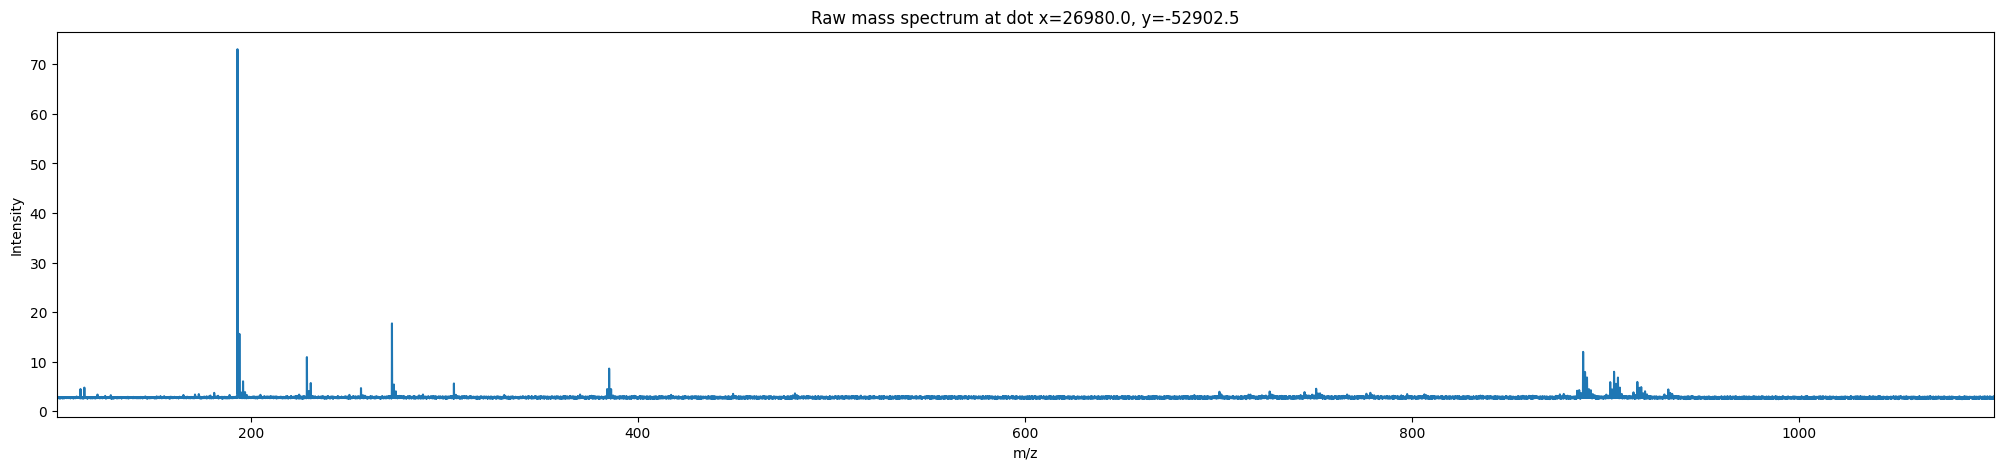

In [6]:
#Выгрузка датасета
int_array_full = data['Rapiflex']['roi1_e046']['00']['int'][:]
print(f"Intensity array shape: {int_array_full.shape}")
spectra_mz = data['Rapiflex']['roi1_e046']['00']['mz'][:] #являются общими для всех для континуальных данных
print(f"mz array shape: {spectra_mz.shape}")
spectra_coords_full = data['Rapiflex']['roi1_e046']['00']['xy'][:]
print(f"Coordinates array shape: {spectra_coords_full.shape}")

#Выгрузим интенсивности масс-спектра из одной точки с его координатами 
spectrum_int = data['Rapiflex']['roi1_e046']['00']['int'][4242,:]
spectrum_coords = data['Rapiflex']['roi1_e046']['00']['xy'][4242,:]

#Построим масс-спектр
plt.figure(figsize=(25,5))
plt.plot(spectra_mz,spectrum_int)
plt.title(f'Raw mass spectrum at dot x={spectrum_coords[0]}, y={spectrum_coords[1]}')
plt.ylabel('Intensity')
plt.xlabel('m/z')
plt.xlim((min(spectra_mz),max(spectra_mz)))
plt.show()